In [1]:
import meshio
import pygmsh
import pygalmesh
import numpy as np
import copy
from mshr import *
from dolfin import *
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *
import numba
from timeit import default_timer as timer

In [ ]:
# root folder for data
DataFolder=os.getcwd()+'/Data/Scratch'
# Folder for the run data"

# Testing the Mesh Generation

Make a mesh with pygmsh, with some dummy values to play with:

In [ ]:
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = 0.1
    ellipsoid = geom.add_ball([0.0, 0.0, 0.0], 1)
    InputMesh = geom.generate_mesh()

In [ ]:
interiorbonds,edgebonds,boundarytris, bidxTotidx, tetras= MakeMeshData3D(InputMesh)
bonds=np.concatenate((interiorbonds,edgebonds))
orientedboundarytris=OrientTriangles(InputMesh.points,boundarytris,np.array([0,0,0]))

In [ ]:
cells=[ ("line", bonds ), ("triangle",boundarytris ), ("tetra",tetras)]
isbond=  np.ones(len(bonds))
isedgebond= np.concatenate( ( np.zeros(len(interiorbonds)),np.ones(len(edgebonds)) ) )
CellDataDict={'isedgebond':[isedgebond,np.zeros(len(boundarytris)),np.zeros(len(tetras))]
              ,'isbond':[isbond,np.zeros(len(boundarytris)),np.zeros(len(tetras))]}

OutputMesh=meshio.Mesh(InputMesh.points, cells, {},CellDataDict)
OutputMesh.write(DataFolder+"InitialMesh.vtk",binary=True) 

## Testing the boundary triangle finding

when pygmsh generates a sphere, it gives the tetrahedrons and boundary triangles. We can use this to check our bondary finding is working. First, make the ball. Now, compare the lists of boundary triangles that we find to those that pygmsh finds. We need to sort the pygmsh ones, as the vertices dont always appear in ascending order

In [ ]:
np.array_equal(boundarytris,np.sort(InputMesh.cells[1].data,axis=1))

In [ ]:
boundarytris.shape

In [ ]:
InputMesh.cells[1].data.shape

This seems a good verification that our boundary list is correct

## Check total surface area

For a sphere

In [ ]:
vTotalArea3D(InputMesh.points,boundarytris)

In [ ]:
4*np.pi

## Check total volume

Ive written two functions which do this, lets check both

In [ ]:
Volume3D(InputMesh.points,orientedboundarytris,bidxTotidx).sum()

In [ ]:
Volume3D_tetras(InputMesh.points,tetras).sum()

In [ ]:
(4/3)*np.pi

# Physical Tests

## Checking the Bending Modulus Energy

 As implemented, the bending modulus approximates the continuum limit $F= \frac{\kappa_c}{2}\int dA(C_1+C_2-C_0)^2 + k_g \int dA C_1C_2$ for a closed surface, where $C_1$ etc. are the principal curvatures. According to Boal and Rao 1992, the energy of a sphere  without a spontaneous curvature is $\frac{4\pi k_{rig}}{\sqrt{3}}$, where $k_{rig}$ is the microscopic modulus.  This seems to be true for a triangulation by equilateral triangles. Lets check this:

In [ ]:
theta_0=0
kbend=1
energies= BendingEnergy(InputMesh.points,orientedboundarytris,bidxTotidx,kbend)
energies.sum()

In [ ]:
(4/np.sqrt(3))*np.pi

## Checking the Spring Energy

A basic test: lets just make 2 springs (to check the vectorization), and confirm their behaviour. We are supposed to be implementing:

$V(r,r_0) = k_{\mathrm{neo}}\left( \frac{1-\alpha}{2}\left(\frac{1}{\lambda}+2\lambda^2\right)+\frac{\alpha}{2}\left(\frac{1}{\lambda^2}+2\lambda\right) \right)$, where $V=r/r_0$, and $k_{neo}=\frac{r_0^2 k_{hook}}{3}$. Some tests:

$V(1)= \frac{1}{2} k_{hook} r_0^2$, indepdent of the mat non.

In [ ]:
MatNon=1
khook=1
#rest lengths
r0_ij=np.array([1,2])
SpringEnergy=NeoHookean3D(r0_ij,r0_ij,khook,MatNon)
print(SpringEnergy) 

In [ ]:
np.log(0.5)

Plotting the energy: Pure Neohookean on a loglogplot. Expectation: Minimum at $(0,log(0.5)$=$(0,-0.693)$ Asmptotes to grad -1 and grad 2 in either limit.

Pure MR: same minimum, but the opposite grad behaviours

In [ ]:
lam=np.arange(0.1, 10, 0.01);
MatNon=0
khook=1
Energy=NeoHookean3D(lam,1,khook,MatNon)
plt.plot(np.log(lam),np.log(Energy))

MatNon=1
khook=1
Energy=NeoHookean3D(lam,1,khook,MatNon)
plt.plot(np.log(lam),np.log(Energy))

In [ ]:
lam=10**10
MatNon=0
khook=1
print(( np.log(NeoHookean3D(lam,1,khook,MatNon))-np.log(NeoHookean3D(1,1,khook,MatNon)) )/(np.log(lam)))
lam=10**(-10)
MatNon=0
khook=1
print(( np.log(NeoHookean3D(lam,1,khook,MatNon))-np.log(NeoHookean3D(1,1,khook,MatNon)) )/(np.log(lam)))


In [ ]:
lam=10**10
MatNon=1
khook=1
print(( np.log(NeoHookean3D(lam,1,khook,MatNon))-np.log(NeoHookean3D(1,1,khook,MatNon)) )/(np.log(lam)))
lam=10**(-10)
MatNon=1
khook=1
print(( np.log(NeoHookean3D(lam,1,khook,MatNon))-np.log(NeoHookean3D(1,1,khook,MatNon)) )/(np.log(lam)))


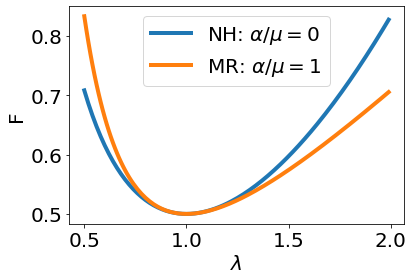

In [32]:
matplotlib.rcParams.update({'font.size': 20})
lam=np.arange(0.5,2 , 0.01);
MatNon=0
khook=1
Energy=NeoHookean3D(lam,1,khook,MatNon)
plt.plot((lam),(Energy),linewidth=4.0)

MatNon=1
khook=1
Energy=NeoHookean3D(lam,1,khook,MatNon)
plt.plot((lam),(Energy),linewidth=4.0)

plt.xlabel('$\lambda$')
plt.ylabel('F')
plt.legend(['NH: $\\alpha/\mu=0$','MR: $\\alpha/\\mu=1$'],prop={'size':20})
plt.savefig("Energies.png", bbox_inches='tight',dpi=400)

<Figure size 432x288 with 0 Axes>

# Checking that the Numba versions of functions match the regular ones

Lets generate a problem similar to our own:

In [ ]:
# Target mesh size:
target_a = 0.2
# continuum bending modulus:
kc=0.5
# continuum shear modulus:
mu=1
# Energetic penalty for volume change
B=100000
# The Material Nonlinearity parameter, between 0 and 1
MatNon=0.99
# the spring prestress values 
g0=1

# The microscopic values
kbend=kc/target_a
khook = mu
theta0=0.2

In [ ]:
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = target_a
    ellipsoid = geom.add_ball([0.0, 0.0, 0.0], 1)
    #ellipsoid = geom.add_ellipsoid([0.0, 0.0, 0.0], [0.95, 0.95, 1.05])
    InputMesh = geom.generate_mesh()

In [ ]:
interiorbonds,edgebonds,boundarytris, bidxTotidx, tetras= MakeMeshData3D(InputMesh)
bonds=np.concatenate((interiorbonds,edgebonds))
orientedboundarytris=OrientTriangles(InputMesh.points,boundarytris,np.array([0,0,0]))
boundarytris=orientedboundarytris

In [ ]:
# make the preferred rest lengths of the interior springs
interiorpairs=InputMesh.points[interiorbonds]
interiorvecs = np.subtract(interiorpairs[:,0,:],interiorpairs[:,1,:])
InteriorBondRestLengths=np.linalg.norm(interiorvecs,axis=1)

# make the preferred rest lengths of the edge springs. Initially have the at g0=1, but then
#update them in the loop
edgepairs=InputMesh.points[edgebonds]
edgevecs = np.subtract(edgepairs[:,0,:],edgepairs[:,1,:])
InitialEdgeBondRestLengths=np.linalg.norm(edgevecs,axis=1)

# The volume constraint is simply that the target volume should be the initial volume
TargetVolumes=Volume3D_tetras(InputMesh.points,tetras)

P =InputMesh.points

 # the important bit! Giving it the prestress
EdgeBondRestLengths= g0*InitialEdgeBondRestLengths
r0_ij=np.concatenate((InteriorBondRestLengths,EdgeBondRestLengths))    
   

To test numerical equality, we can use numpy's testing module:
https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_allclose.html#numpy.testing.assert_allclose


In [ ]:
x=Volume3D_tetras(P,tetras)
Numbax=NumbaVolume3D_tetras_2(P,tetras)
np.testing.assert_allclose(x,Numbax)

In [ ]:
x=BendingEnergy(P,orientedboundarytris,bidxTotidx,kbend)
Numbax=NumbaBendingEnergy_2(P,orientedboundarytris,bidxTotidx,kbend)
np.testing.assert_allclose(x,Numbax)

In [ ]:
x=energy3D(P,bonds,orientedboundarytris,bidxTotidx,tetras,r0_ij,khook,kbend,theta0,B,MatNon,TargetVolumes)
Numbax=Numbaenergy3D(P,bonds,orientedboundarytris,bidxTotidx,tetras,r0_ij,khook,kbend,theta0,B,MatNon,TargetVolumes)
np.testing.assert_allclose(x,Numbax)

## Checking Timings

## volume

In [ ]:
start = timer()
for i in range(0,5000):
    x=Volume3D_tetras(P,tetras)
end = timer()
print(end-start)

In [ ]:
start = timer()
for i in range(0,5000):
    x=NumbaVolume3D_tetras2(P,tetras)
end = timer()
print(end-start)

## Bending

In [ ]:
start = timer()
for i in range(0,5000):
    x=BendingEnergy(P,orientedboundarytris,bidxTotidx,kbend)
end = timer()
print(end-start)

In [ ]:
start = timer()
for i in range(0,5000):
    x=NumbaBendingEnergy_2(P,orientedboundarytris,bidxTotidx,kbend)
end = timer()
print(end-start)

## Spring

In [ ]:
start = timer()
for i in range(0,5000):
    x=NeoHookean3D(r0_ij,r0_ij,khook,MatNon).sum()   
end = timer()
print(end-start)

In [ ]:
start = timer()
for i in range(0,5000):
       x=NumbaNeoHookean3D(r0_ij,r0_ij,khook,MatNon).sum()  
end = timer()
print(end-start)

## Making Spring rests

In [ ]:
start = timer()
for i in range(0,5000):
    # We convert it to a matrix here.
    P_ij = P.reshape((-1, 3))
    # from the bond list, work out what the current bond lengths are:
    AB=P_ij[bonds]
    t1 = np.subtract(AB[:,0,:],AB[:,1,:])
    r_ij=np.linalg.norm(t1,axis=1)
end = timer()
print(end-start)
    

In [ ]:
start = timer()
for i in range(0,5000):
    # We convert it to a matrix here.
    P_ij = P.reshape((-1, 3))
    r_ij=NumbaMakeBondLengths(P_ij,bonds)
end = timer()
print(end-start)

## Totals

In [ ]:
start = timer()
for i in range(0,5000):
    x=energy3D(P,bonds,orientedboundarytris,bidxTotidx,tetras,r0_ij,khook,kbend,theta0,B,MatNon,TargetVolumes)
end = timer()
print(end-start)

In [ ]:
start = timer()
for i in range(0,5000):
    Numbax=Numbaenergy3D(P,bonds,orientedboundarytris,bidxTotidx,tetras,r0_ij,khook,kbend,theta0,B,MatNon,TargetVolumes)
end = timer()
print(end-start)